# XGBoost 파이썬 래퍼

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


In [ ]:
dtrain = xgb.DMatrix(data=X_train , label=y_train, feature_names=dataset.feature_names)
dtest = xgb.DMatrix(data=X_test , label=y_test, feature_names=dataset.feature_names)

In [ ]:
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

In [ ]:
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , \
                      early_stopping_rounds=100, evals=wlist )

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


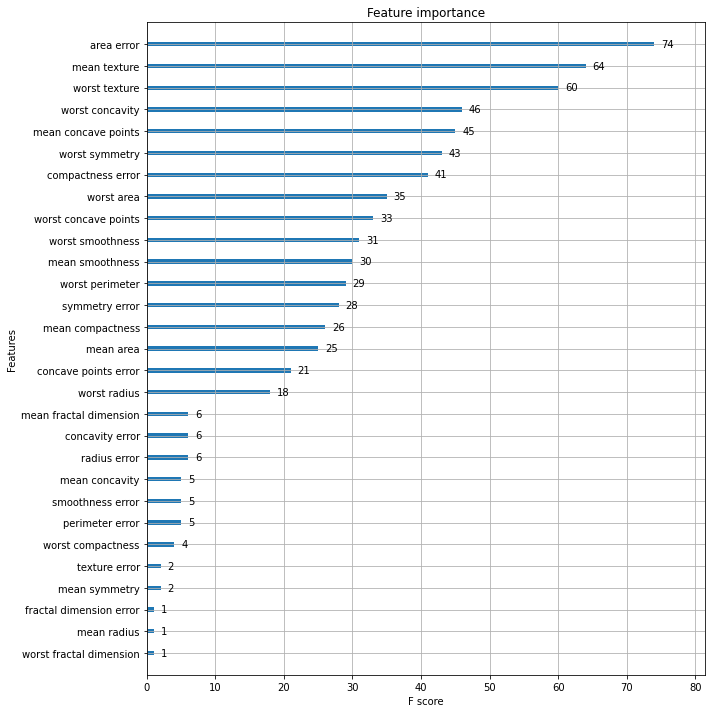

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

# XGBoost 사이킷런 래퍼

- 주요 일반 파라미터 : 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터
 - booster='gbtree'  : 부스터 선택
 - silent=None,  : 출력메시지의 여부
 - nthread=None,  : CPU의 실행 스레드 개수를 조정

- 주요 부스터 파라미터 : 트리 최적화, 부스팅, 등과 관련 파라미터 등 을 지칭
 - learning_rate=0.1, 
 - n_estimators=100, 
 - min_child_weight=1, 
 - gamma=0, 
 - max_depth=3,
 - subsample=1, 
 - colsample_bytree=1, 
 - reg_lambda=1, 
 - reg_alpha=0, 
 - scale_pos_weight=1, 

- 학습 태스크 파라미터 : 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터
 - objective='binary:logistic',  
 - eval_metric

In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(cancer_df.iloc[:, :-1], cancer_df.iloc[:, -1],
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


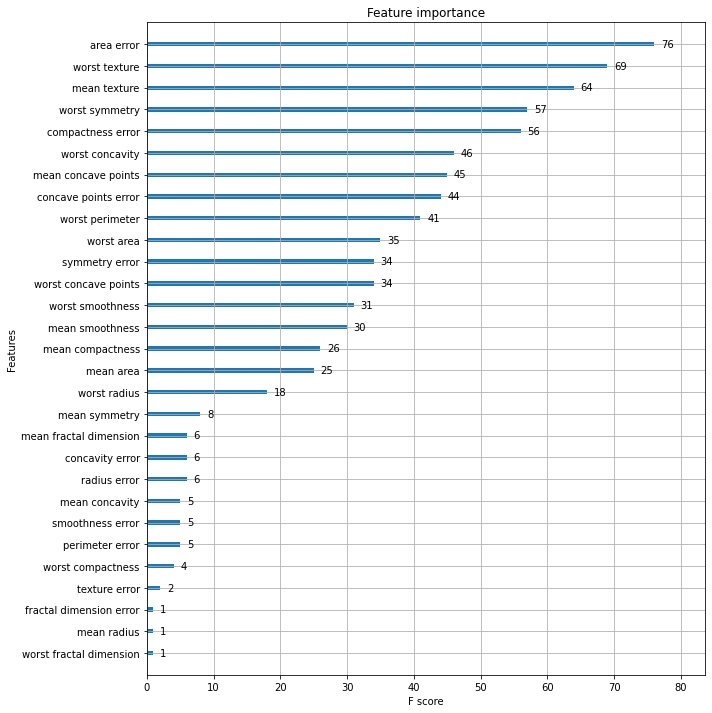

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

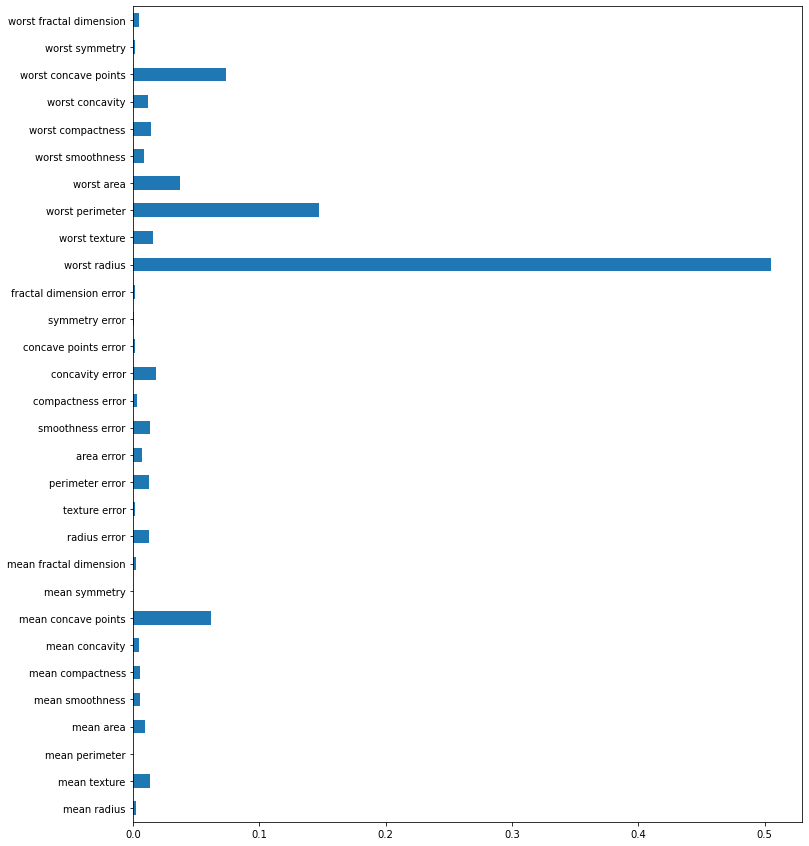

In [ ]:
plt.figure(figsize=(12,15))
pd.Series(index = X_train.columns, data = xgb_wrapper.feature_importances_).plot.barh()

- 'weight’: the number of times a feature is used to split the data across all trees.

- ‘gain’: the average gain across all splits the feature is used in.

- ‘cover’: the average coverage across all splits the feature is used in.

- ‘total_gain’: the total gain across all splits the feature is used in.

- ‘total_cover’: the total coverage across all splits the feature is used in.

In [ ]:
# importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
xgb_wrapper.get_booster().get_score(importance_type='weight')

{'area error': 76,
 'compactness error': 56,
 'concave points error': 44,
 'concavity error': 6,
 'fractal dimension error': 1,
 'mean area': 25,
 'mean compactness': 26,
 'mean concave points': 45,
 'mean concavity': 5,
 'mean fractal dimension': 6,
 'mean radius': 1,
 'mean smoothness': 30,
 'mean symmetry': 8,
 'mean texture': 64,
 'perimeter error': 5,
 'radius error': 6,
 'smoothness error': 5,
 'symmetry error': 34,
 'texture error': 2,
 'worst area': 35,
 'worst compactness': 4,
 'worst concave points': 34,
 'worst concavity': 46,
 'worst fractal dimension': 1,
 'worst perimeter': 41,
 'worst radius': 18,
 'worst smoothness': 31,
 'worst symmetry': 57,
 'worst texture': 69}